<h2 style='color:blue' align='center'>Sports Celebrity Image Classification<h2>

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:purple'>(1) Preprocessing: Detect face and eyes</h3>

#### The first step in the pre-processing pipeline is to detect faces from an image. In order to clean our data, once a face is detected, we will detect eyes. If two eyes are then detected,we keep the image.Otherwise, we delete it</h4>

I use haar cascade to detect the faces and eyes from the images. First, we use a clear image with a face and two eyes

In [2]:
img = cv2.imread('./test_images/irving1.jpg')
img.shape

(600, 1000, 3)

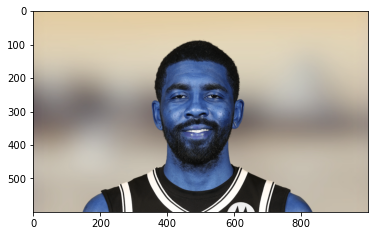

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(600, 1000)

In [5]:
gray

array([[190, 189, 190, ..., 192, 192, 192],
       [190, 190, 191, ..., 192, 192, 191],
       [190, 190, 190, ..., 192, 193, 192],
       ...,
       [175, 175, 175, ..., 184, 185, 185],
       [175, 175, 175, ..., 184, 185, 185],
       [176, 175, 175, ..., 184, 185, 185]], dtype=uint8)

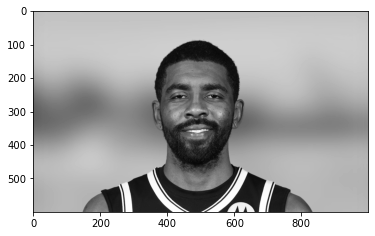

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[346, 141, 284, 284]], dtype=int32)

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(346, 141, 284, 284)

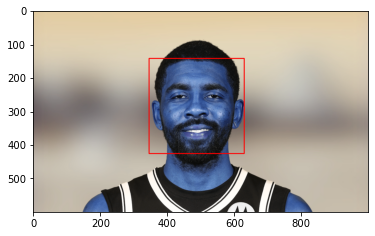

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

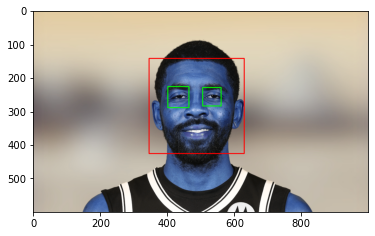

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

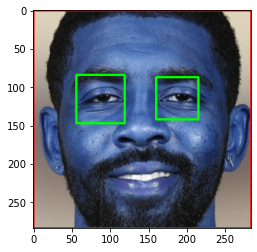

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(284, 284, 3)

<h3 style='color:purple'>Use wavelet transform as a feature for traning the model</h3>

#### A wavelet transformed image allows you to see the edges of the face clearly.This allows the model to distinguish specific facial features.

### Wavelet transform

In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

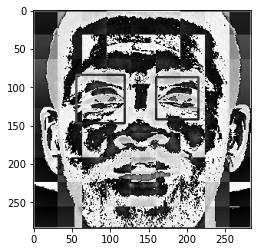

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### I will use the wavelet transformed image as seen above,along with the raw pixel image as an input for the classifier

####  Below is a function that can take an input image,detect face and eyes within the image and returns a cropped image if face and 2 or more eyes are detected

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

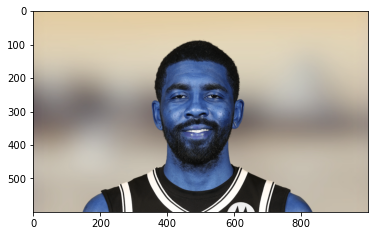

In [16]:
original_image = cv2.imread('./test_images/irving1.jpg')
plt.imshow(original_image)

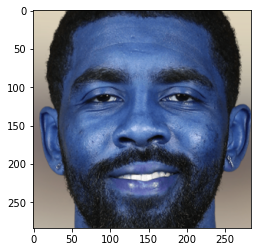

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/irving1.jpg')
plt.imshow(cropped_image)

**Using an image where the face is clearly obstructed with no eyes shown**

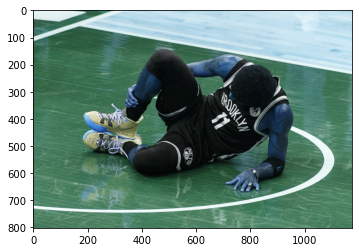

In [18]:
org_image_obstructed = cv2.imread('./test_images/irving2.jpg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/irving2.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means this image should be ignored and not used for model training**

In [20]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/a_cropped/"

In [21]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [22]:
img_dirs

['./dataset/bradley_beal',
 './dataset/giannis_antetokounmpo',
 './dataset/jayson_tatum',
 './dataset/kawhi_leonard',
 './dataset/kyrie_irving',
 './dataset/lebron_james',
 './dataset/luka_doncic',
 './dataset/nikola_jokic',
 './dataset/stephen_curry',
 './dataset/zion_williamson']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [23]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/a_cropped/bradley_beal
Generating cropped images in folder:  ./dataset/a_cropped/giannis_antetokounmpo
Generating cropped images in folder:  ./dataset/a_cropped/jayson_tatum
Generating cropped images in folder:  ./dataset/a_cropped/kawhi_leonard
Generating cropped images in folder:  ./dataset/a_cropped/kyrie_irving
Generating cropped images in folder:  ./dataset/a_cropped/lebron_james
Generating cropped images in folder:  ./dataset/a_cropped/luka_doncic
Generating cropped images in folder:  ./dataset/a_cropped/nikola_jokic
Generating cropped images in folder:  ./dataset/a_cropped/stephen_curry
Generating cropped images in folder:  ./dataset/a_cropped/zion_williamson


### There may be some images in the cropped folder that are blurry, of a different person, or just bad data. Manually examine the folder and delete any unwanted images

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'bradley_beal': ['./dataset/a_cropped/bradley_beal\\bradley_beal1.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal10.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal11.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal12.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal13.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal14.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal15.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal16.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal17.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal18.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal19.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal2.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal20.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal21.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal22.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal23.png',
  './dataset/a_cropped/bradley_beal\\bradley_beal24.png',


**For the UI-part of the project, I need the class dictionary which assigns each player as a unique number**

In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'bradley_beal': 0,
 'giannis_antetokounmpo': 1,
 'jayson_tatum': 2,
 'kawhi_leonard': 3,
 'kyrie_irving': 4,
 'lebron_james': 5,
 'luka_doncic': 6,
 'nikola_jokic': 7,
 'stephen_curry': 8,
 'zion_williamson': 9}

### Images in the cropped folder can be used for model training. These raw images, along with their wavelet transformed counterpart, will be used to train the classifier. In the next few cells, I prepare X and y for training

In [27]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [28]:
len(X[0])

4096

In [29]:
32*32*3 + 32*32

4096

In [30]:
X[0]

array([[43],
       [40],
       [56],
       ...,
       [62],
       [63],
       [52]], dtype=uint8)

In [31]:
y[0]

0

In [32]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(395, 4096)

### The data cleaning process is now done. The model is ready to be trained

SVM will be used with rbf kernel tuned and heuristic finetuning

In [33]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7474747474747475

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.84      1.00      0.91        16
           2       0.56      0.83      0.67        12
           3       0.50      0.71      0.59         7
           4       1.00      0.92      0.96        13
           5       1.00      0.78      0.88         9
           6       0.83      0.42      0.56        12
           7       0.90      0.82      0.86        11
           8       0.38      0.75      0.50         4
           9       1.00      0.75      0.86         4

    accuracy                           0.75        99
   macro avg       0.77      0.73      0.72        99
weighted avg       0.79      0.75      0.75        99



### I use GridSearch to try out different models with different paramets. The goal is to come up with best model with the best fine tuned parameters

In [36]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [38]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.672429,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.395254,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.749831,{'logisticregression__C': 1}


In [39]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [40]:
best_estimators['svm'].score(X_test,y_test)

0.7676767676767676

In [41]:
best_estimators['random_forest'].score(X_test,y_test)

0.42424242424242425

In [42]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8080808080808081

In [43]:
best_clf = best_estimators['svm']

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 7,  1,  0,  2,  0,  0,  0,  0,  0,  1],
       [ 0, 16,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  9,  0,  0,  0,  1,  0,  1,  0],
       [ 1,  0,  0,  5,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  1,  5,  0,  0,  1,  0],
       [ 0,  0,  3,  1,  1,  0,  5,  0,  2,  0],
       [ 0,  0,  1,  0,  0,  0,  1,  9,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4]], dtype=int64)

Text(69.0, 0.5, 'Truth')

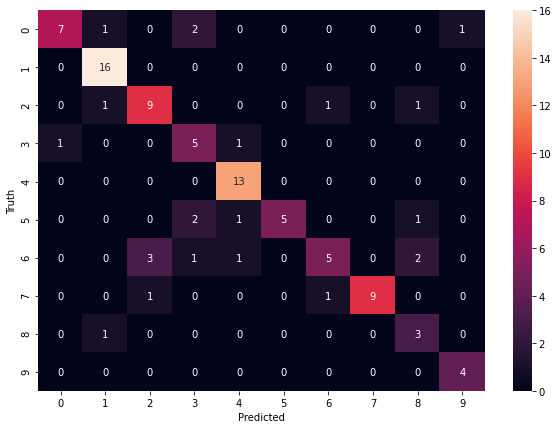

In [45]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
class_dict

{'bradley_beal': 0,
 'giannis_antetokounmpo': 1,
 'jayson_tatum': 2,
 'kawhi_leonard': 3,
 'kyrie_irving': 4,
 'lebron_james': 5,
 'luka_doncic': 6,
 'nikola_jokic': 7,
 'stephen_curry': 8,
 'zion_williamson': 9}

### Save the trained model

In [47]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [48]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))